Solves the following differential equation

  ```-d/dx (p(x) du/dx) + q(x)*u  =  f(x)```

by the Finite Element Method (FEM) using linear basis functions.

```u``` is an unknown function defined on ```[x0, x1]```, and ```p```, ```q``` and ```f``` are known functions of ```x```.

Essential boundary condition is applied at the left end.

Natural   boundary condition is applied at the right end.




---



Standard imports.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

import sys

Analytical solution.

In [ ]:
def exact(x):
  return (4. * np.pi - (16. * np.pi * np.pi + 1.) / (4. * np.pi)) * x +  np.sin ( 4. * np.pi * x )

Gaussian quadrature function.

In [ ]:
def gaussianQuadrature(ngp):

  gaussPoints       = np.zeros((ngp, 1))
  gaussWeights      = np.zeros((ngp, 1))
  
  # --- 1 Gauss point
  if (ngp == 1):       
    gaussPoints     = 0
    gaussWeights    = 2

  # --- 2 Gauss points
  elif (ngp == 2):   
    gaussPoints[0]  = - 0.577350269189625764509148780502
    gaussPoints[1]  =   0.577350269189625764509148780502

    gaussWeights[0] = 1.0
    gaussWeights[1] = 1.0

  # --- 3 Gauss points
  elif (ngp == 3):    

    gaussPoints[0]  = - 0.774596669241483377035853079956
    gaussPoints[1]  =   0.0;
    gaussPoints[2]  =   0.774596669241483377035853079956

    gaussWeights[0] = 5.0 / 9.0
    gaussWeights[1] = 8.0 / 9.0
    gaussWeights[2] = 5.0 / 9.0
    
  # --- 4 Gauss points
  elif (ngp == 4): 

    gaussPoints[0]  = - 0.861136311594052575223946488893
    gaussPoints[1]  = - 0.339981043584856264802665759103
    gaussPoints[2]  =   0.339981043584856264802665759103
    gaussPoints[3]  =   0.861136311594052575223946488893

    gaussWeights[0] = 0.347854845137453857373063949222
    gaussWeights[1] = 0.652145154862546142626936050778
    gaussWeights[2] = 0.652145154862546142626936050778
    gaussWeights[3] = 0.347854845137453857373063949222

  # --- 5 Gauss points
  elif (ngp == 5): 

    gaussPoints[0]  = - 0.906179845938663992797626878299
    gaussPoints[1]  = - 0.538469310105683091036314420700
    gaussPoints[2]  =   0.0
    gaussPoints[3]  =   0.538469310105683091036314420700
    gaussPoints[4]  =   0.906179845938663992797626878299

    gaussWeights[0] = 0.236926885056189087514264040720
    gaussWeights[1] = 0.478628670499366468041291514836
    gaussWeights[2] = 0.568888888888888888888888888889
    gaussWeights[3] = 0.478628670499366468041291514836
    gaussWeights[4] = 0.236926885056189087514264040720

  else:

    print("\nGaussian quadrature - Fatal error! \n")
    print("Illegal number of Gauss points = ", ngp, "\n")
    print("Legal values are 1 to 5.\n")
    sys.exit()

  return gaussPoints, gaussWeights

Linear basis functions calculation.

In [ ]:
def LinearBasisFunctions1D(xi):

  # --- Calculate the two basis functions at the natural coordinate xi
  N1e  = (1 / 2) * (1 - xi)
  N2e  = (1 / 2) * (xi + 1)
  Ne   = np.array([N1e, N2e])

  # --- Calculate the derivatives of the basis function with respect to natural coordinate xi
  dN1e = -1 / 2
  dN2e = 1 / 2
  dNe  = np.array([dN1e, dN2e])

  return Ne, dNe

```p(x)``` function.

In [ ]:
def p(x):

  return 1.0

```f(x)``` function.

In [ ]:
def ff(x):

  return (16 * np.pi * np.pi + 1) * np.sin(4 * np.pi * x)

Linear system solution function.

In [ ]:
def SolveSystem(K, f, globalIndicesSpecifiedValues, specifiedDegreesOfFreedom):

  dof = f.size                    # --- Extract the total number of degreess-of-freedom                   

  # --- Separate the degrees of freedom to the boundary condition points
  #     C = setdiff(A,B) for vectors A and B, returns the values in A that are not in B with no 
  #     repetitions. C will be sorted.
  df = np.setdiff1d(range(dof), globalIndicesSpecifiedValues)

  # Kf = csr_matrix((dof - 1, dof - 1))
  Kf = lil_matrix((dof - 1, dof - 1))
  for p in range(dof - 1):
    for q in range(dof - 1):
      if (K[df[p], df[q]] != 0):
        Kf[p, q] = K[df[p], df[q]]

  Rf = f[df] - K[df, globalIndicesSpecifiedValues] * specifiedDegreesOfFreedom

  # --- Solve the linear system of equations using Gauss elimination. Other (possibly more efficient)
  #     solution schemes are possible, taking also advantage of the sparse matrix data structure.
  dfVals = spsolve(Kf.tocsr(), Rf)

  d = np.zeros((dof, 1))                  # --- Restore the solution vector
  d[globalIndicesSpecifiedValues] = specifiedDegreesOfFreedom
  d[df, 0]   = dfVals;

  return d


Assemble global matrix function.

In [ ]:
def AssembleGlobalMatrix(e, Ke, fe):

  global numNodesPerElement, connectivityMatrix, f, I, J, X, ntriplets

  for ii in range(numNodesPerElement):                          # --- Loop over all the nodes of the e-th element
    
    globalIndexii = connectivityMatrix[e, ii]                   # --- Global index of the ii-th local node of the e-th element
       
    if (fe[ii] != 0):
        f[globalIndexii] = f[globalIndexii] + fe[ii]            # --- Assemble load
        
    for jj in range(numNodesPerElement):                        # --- Loop over all the nodes of the e-th element
        
        globalIndexjj = connectivityMatrix[e, jj]               # --- Global index of the ii-th local node of the e-th element
            
        # --- If the element (ii, jj) of the stiffness matrix of the e-th element is different from zero, then add a triplet
        if (Ke[ii, jj] != 0):                            
            
            ntriplets = ntriplets + 1
                                        
            # --- Manually increase the size of the I, J, X arrays if needed, namely, it ntriplets > len. 
            #     The below approach speeds up this process. All the values of these arrays 
            #     between len and 2*len are set to zero and the length of these arrays is increased to 2*len    
            lenX = X.size                 
            if (ntriplets >= X.size): 
                I.resize((2 * lenX, 1))
                J.resize((2 * lenX, 1))
                X.resize((2 * lenX, 1))
                I[2 * lenX - 1] = 0
                J[2 * lenX - 1] = 0      
                X[2 * lenX - 1] = 0      

            I[ntriplets] = globalIndexii
            J[ntriplets] = globalIndexjj
            X[ntriplets] = Ke[ii, jj]

Parameters

In [ ]:
x0                      = 0.0                                   # --- Left end of the 1D domain
x1                      = 1.0                                   # --- Right end of the 1D domain

numElements             = 50                                    # --- Total number of elements

totalNumNodes           = numElements + 1                       # --- Total number of nodes
numNodesPerElement      = 2                                     # --- Number of nodes per element
     
numberGaussPoints       = 2                                     # --- Number of Gauss points

Nodes and connectivity matrix.

In [ ]:
globalNodes             = np.linspace(x0, x1, totalNumNodes)    # --- Global node coordinates

# --- Connectivity matrix
connectivityMatrix      = np.zeros((numElements, numNodesPerElement), dtype = np.int32)              
     
# --- Loop over all elements
for e in range(numElements):
    connectivityMatrix[e, 0] = e       
    connectivityMatrix[e, 1] = e + 1   

Global matrices and vectors.

In [ ]:
f                         = np.zeros((totalNumNodes, 1))          # --- Global force vector
d                         = np.zeros((totalNumNodes, 1))          # --- Global solution vector

gaussPoints, gaussWeights = gaussianQuadrature(numberGaussPoints)     # --- Return Gauss quadrature points and weights                      

# --- Triplet for assembling the sparse matrix
I           = np.zeros((numNodesPerElement * totalNumNodes, 1), dtype = np.int32)       # --- Row indices of non-zero entries
J           = np.zeros((numNodesPerElement * totalNumNodes, 1), dtype = np.int32)       # --- Column indices of non-zero entries
X           = np.zeros((numNodesPerElement * totalNumNodes, 1))                         # --- Non-zero entries matrix

ntriplets   = -1                                                      # --- Global variable to trace the index

############
# FEM LOOP #
############
for e in range(numElements):     # --- Loop over the elements

  Ke = np.zeros((numNodesPerElement, numNodesPerElement))             # --- Element stiffness matrix
  fe = np.zeros((numNodesPerElement, 1))                              # --- Element force (load) vector 

  globalNodeNumbers = connectivityMatrix[e, :]                        # --- Global node numbers corresponding to the current element 
  xe                = globalNodes[globalNodeNumbers]                  # --- Global coordinates of the element nodes as a column vector

  # --- Calculate the element integral
  for kk in range(gaussPoints.size):    # --- Loop over all the Gauss points

    Ne, dNe       = LinearBasisFunctions1D(gaussPoints[kk])           # --- Return the 1D linear basis functions along with their derivatives with respect to local coordinates xi at Gauss points

    x             = np.matmul(xe, Ne)                                 # --- Global coordinate (here x) of the current integration point

    Jacobian      = np.matmul(xe, dNe)                                # --- Jacobian dx / dxi

    JacxW         = Jacobian * gaussWeights[kk]                       # --- Calculate the integration weight

    B             = np.reshape(dNe / Jacobian, (numberGaussPoints, 1))   # --- Calculate the derivatives of the basis functions with respect to x direction 

    Ke            = Ke + np.matmul(B, np.transpose(p(x) * B)) * JacxW

    fe            = fe + ff(x) * Ne * JacxW

  AssembleGlobalMatrix(e, Ke, fe)                                     # --- Assemble global matrix

Constructs the global stiffness matrix in sparse format using ```I, J, X```. Any elements of s that have duplicate values of ```i``` and ```j``` are added together. Accordingly, if there are duplicates (which a finite element matrix always has) the duplicates are summed, which is exactly what we want when assembling a finite-element matrix.

In [ ]:
X = np.reshape(X[0 : (ntriplets + 1)], ((ntriplets + 1),))
I = np.reshape(I[0 : (ntriplets + 1)], ((ntriplets + 1),))
J = np.reshape(J[0 : (ntriplets + 1)], ((ntriplets + 1),))
K = csr_matrix((X, (I, J)))

Apply boundary conditions.

In [ ]:
# --- Essential boundary condition (u specified) at first end
globalIndicesSpecifiedValues = 0        # --- Global indices with specified values
specifiedDegreesOfFreedom    = 0        # --- Specified degrees of freedom values

# --- Natural boundary condition (du / dn specified) at the second end
x = globalNodes[totalNumNodes - 1]      # --- Global coordinate of second end
value = 4 * np.pi * np.cos(4 * np.pi);
f[totalNumNodes - 1] = f[totalNumNodes - 1] + p(x) * value; 

Solve the linear system.


In [ ]:
d = SolveSystem(K, f, globalIndicesSpecifiedValues, specifiedDegreesOfFreedom)

Post processing.

In [ ]:
numPlotPointsPerElement  = 10                                             # --- Number of plot points per element

plotPoints               = np.linspace(-1, 1, numPlotPointsPerElement)    # --- Global node coordinates

numberGaussPoints        = 2                                              # --- Number of Gauss points

uniformNorm              = 0.0
l2DifferenceNorm         = 0.0                   
l2Norm                   = 0.0           

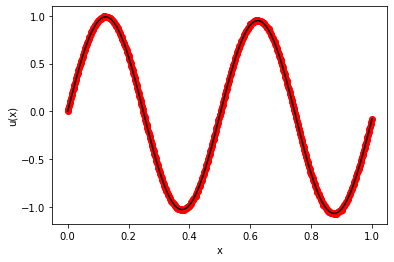

Uniform norm:  [[0.00109031]]
Percentage root mean square error:  [[5.84323186e-05]]


In [ ]:
x_plot = np.zeros((numElements * numPlotPointsPerElement, ))
u_plot = np.zeros((numElements * numPlotPointsPerElement, ))

gaussPoints, gaussWeights = gaussianQuadrature(numberGaussPoints)         # --- Return Gauss quadrature points and weights                      

count = 0
for e in range(numElements):         # --- Loop over the elements

  globalNodeNumbers = connectivityMatrix[e, :]                        # --- Global node numbers corresponding to the current element 
  xe                = globalNodes[globalNodeNumbers]                  # --- Global coordinates of the element nodes as a column vector

  de                = d[globalNodeNumbers]                            # --- Restores the node values

  # --- Loop over all the points for plotting
  for kk in range(numPlotPointsPerElement):

    Ne, _ = LinearBasisFunctions1D(plotPoints[kk])        # --- Return the 1D linear basis functions along with their derivatives with respect to local coordinates xi at 
      
    x  = np.matmul(xe, Ne)                                # --- Global coordinate (here x) of the current integration point
      
    uh = np.matmul(Ne, de)                                # --- Unknown value at plot points

    x_plot[count] = x
    u_plot[count] = uh

    count = count + 1

  # --- Loop over all the Gauss points for error analysis
  for kk in range(gaussPoints.size):        

    Ne, dNe       = LinearBasisFunctions1D(gaussPoints[kk])       # --- Return the 1D linear basis functions along with their derivatives with respect to local coordinates xi at 
                                                                  #     Gauss points
           
    x             = np.matmul(xe, Ne)                             # --- Global coordinate (here x) of the current integration point
                                      
    Jacobian      = np.matmul(xe, dNe)                            # --- Jacobian dx / dxi

            
    JacxW         = Jacobian * gaussWeights[kk]                   # --- Calculate the integration weight
            
    u_exact       = exact(x);                                     # --- Analytical solution

    uh            = np.matmul(np.reshape(de, (1, de.size)), Ne)   # --- Finite element solution at the Gauss points

    # --- Uniform norm
    error = np.abs(uh - u_exact)
    if (error > uniformNorm):
      uniformNorm = error     

    l2DifferenceNorm = l2DifferenceNorm + (u_exact - uh) * (u_exact - uh) * JacxW
    l2Norm           = l2Norm + u_exact * u_exact * JacxW

x_exact = np.linspace(globalNodes[0], globalNodes[totalNumNodes - 1], 100)
u_exact = exact(x_exact)

plt.scatter(x_plot, u_plot, color = 'r')
plt.plot(x_exact, u_exact, color = 'k')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.show()

print("Uniform norm: ", uniformNorm)
print("Percentage root mean square error: ", 100. * l2DifferenceNorm)